<a href="https://colab.research.google.com/github/selvanath-a/ML-repo/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow-gpu==2.0.0-beta1
!pip install imageio
import tensorflow as tf

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os,time
import PIL,imageio
# import glob
from IPython import display
from tensorflow.keras import layers


In [3]:
(train_images,train_labels),(_,_)=tf.keras.datasets.mnist.load_data()
train_images=tf.cast(tf.reshape(train_images,(-1,28,28,1)),tf.float32)
train_images=(train_images-127.5)/127.5

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
BUFFER_SIZE=train_images.shape[0]
BATCH_SIZE=256
train_dataset=tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
def generator_model():
  model=tf.keras.Sequential()
  model.add(layers.Dense(7*7*256,input_shape=(100,),use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7,7,256)))

  model.add(layers.Conv2DTranspose(filters=128,strides=(1,1),kernel_size=(5,5),padding='same',use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(filters=64,strides=(2,2),kernel_size=(5,5),padding='same',use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(filters=1,strides=(2,2),kernel_size=(5,5),padding='same',use_bias=False,activation='tanh'))
  return model

def discriminator_model():
  model=tf.keras.Sequential()
  model.add(layers.Conv2D(filters=64,kernel_size=(5,5),strides=(2,2),padding='same',input_shape=([28,28,1])))
  model.add(layers.LeakyReLU())
  
  model.add(layers.Conv2D(filters=128,kernel_size=(5,5),strides=(2,2),padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.2))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))
  return model

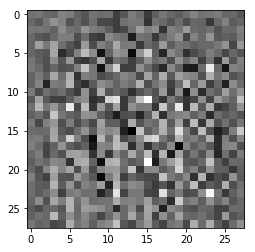

In [6]:
noise=tf.random.normal([1,100])
generator=generator_model()
gen_image=generator(noise,training=False)
plt.imshow(gen_image[0,:,:,0],cmap='gray')
plt.show()


In [7]:
discriminator=discriminator_model()
decision=discriminator(gen_image)
print(decision)

tf.Tensor([[0.00336295]], shape=(1, 1), dtype=float32)


In [0]:
cross_entropy=tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output,fake_output):
  real_loss=cross_entropy(tf.ones_like(real_output),real_output)
  fake_loss=cross_entropy(tf.zeros_like(fake_output),fake_output)
  return real_loss+fake_loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output),fake_output)

In [0]:
gen_optimizer=tf.keras.optimizers.Adam(1e-4)
disc_optimizer=tf.keras.optimizers.Adam(1e-4)

In [0]:
EPOCHS=5
num_images_to_gen=12
noise_dim=100

seed=tf.random.normal([num_images_to_gen,noise_dim])


In [0]:
@tf.function
def train_step(images):
  noise=tf.random.normal([BATCH_SIZE,noise_dim])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_image=generator(noise,training=True)
    
    real_output=discriminator(images,training=True)
    fake_output=discriminator(gen_image,training=True)
    
    gen_loss=generator_loss(fake_output)
    disc_loss=discriminator_loss(real_output,fake_output)
    
  gen_gradients=gen_tape.gradient(gen_loss,generator.trainable_variables)
  disc_gradients=disc_tape.gradient(disc_loss,discriminator.trainable_variables)
  
  gen_optimizer.apply_gradients(zip(gen_gradients,generator.trainable_variables))
  disc_optimizer.apply_gradients(zip(disc_gradients,discriminator.trainable_variables))
  
def generate_and_save_images(model, epoch, test_input):
  preds = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(preds.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(preds[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
  
def train(dataset,epochs):
  for epoch in range(epochs):
    for image_batch in dataset:
      train_step(image_batch)
      display.clear_output(wait=True)
      generate_and_save_images(generator,epoch,seed)
    
      
  display.clear_output(wait=True)
  generate_and_save_images(generator,epochs,seed)
    
    

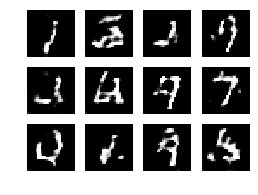

In [15]:
# Raising the number of epochs generates a better result. 
train(train_dataset,EPOCHS)
